In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

# print("Path to dataset files:", path)

# Update dataset_path variable with the correct path
# dataset_path = path

In [2]:
import os

# Replace with the actual path you got from kagglehub.dataset_download
dataset_path = r"C:\Users\thain\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1"

# List all files and directories in the dataset path
files_in_dataset = os.listdir(dataset_path)

# Print the list of files
print("Files in the dataset:")
for file_name in files_in_dataset:
    print(file_name)

Files in the dataset:
images
labels.csv
sprites.npy
sprites_labels.npy


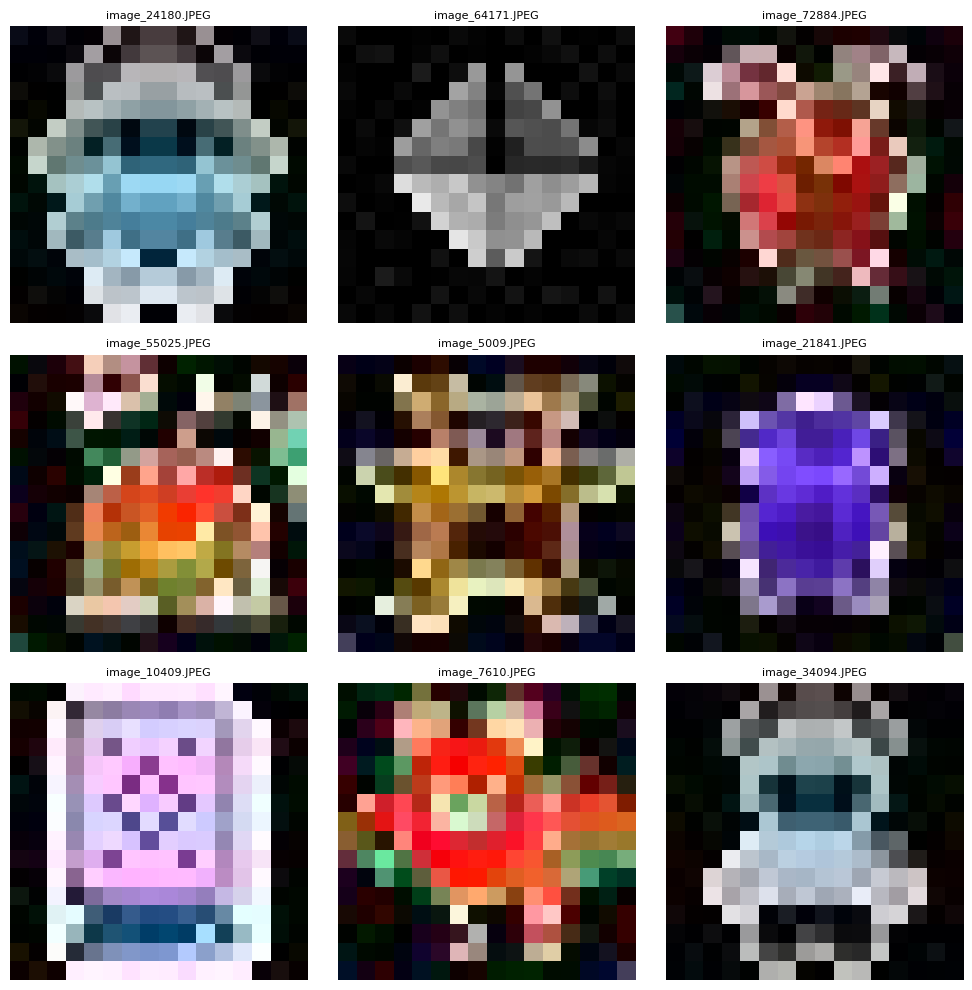

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Path to images directory
images_path = os.path.join(dataset_path, "images", "images")

# List all image files
image_files = os.listdir(images_path)

# Filterเฉพาะไฟล์ภาพ (ป้องกันกรณีมีไฟล์อื่น)
valid_ext = [".png", ".jpg", ".jpeg"]
image_files = [f for f in image_files if os.path.splitext(f)[1].lower() in valid_ext]

# กำหนดจำนวนภาพที่ต้องการโชว์
num_images = 9

if image_files:
    # เลือกสุ่ม n ภาพจากทั้งหมด
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    # คำนวณ layout เช่น 3x3 grid
    cols = 3
    rows = (len(selected_files) + cols - 1) // cols

    plt.figure(figsize=(10, 10))
    for idx, filename in enumerate(selected_files):
        img_path = os.path.join(images_path, filename)
        try:
            img = Image.open(img_path)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            plt.title(filename, fontsize=8)
            plt.axis("off")
        except Exception as e:
            print(f"Could not open image {filename}: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("No image files found in the images directory.")


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Ensure img_shape and latent_dim are defined
# Assuming img_shape is (3, 16, 16) and latent_dim is 100 based on previous successful steps
img_shape = (3, 16, 16)
latent_dim = 100

# Define Generator architecture to output 16x16 images using ConvTranspose2d
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.channels, self.height, self.width = img_shape

        # Initial linear layer to project latent vector to a feature map
        # For 16x16 output with two ConvTranspose2d layers with stride 2,
        # the initial spatial size needed before upsampling is 16 // (2 * 2) = 4
        self.init_size = self.height // 4 # Should be 4 for 16x16 output
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size * self.init_size))


        self.conv_blocks = nn.Sequential(
            # Input: 128 x 4 x 4
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1), # Output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: 128 x 8 x 8
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # Output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Final convolutional layer to output the image: 64 x 16 x 16 -> 3 x 16 x 16
            nn.Conv2d(64, self.channels, 3, stride=1, padding=1),
            nn.Tanh() # Output pixel values in [-1, 1]
        )


    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define Discriminator architecture using Conv2d layers for 16x16 input
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.channels, self.height, self.width = img_shape

        self.conv_layers = nn.Sequential(
            # Input: channels x 16 x 16
            nn.Conv2d(self.channels, 32, 3, stride=2, padding=1), # Output: 32 x 8 x 8 (approx)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Input: 32 x 8 x 8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # Output: 64 x 4 x 4 (approx)
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Input: 64 x 4 x 4
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # Output: 128 x 2 x 2 (approx)
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

        # Calculate the input size for the linear layer based on the output of conv_layers
        # For 16x16 input and the defined conv layers, the output is 128x2x2
        flattened_size = 128 * (self.height // 8) * (self.width // 8) # Should be 128 * 2 * 2 = 512

        self.linear_layer = nn.Sequential(
             nn.Flatten(), # Flatten the output for the linear layer
             nn.Linear(flattened_size, 1), # Final output size
             nn.Sigmoid() # Output a single value between 0 and 1
        )


    def forward(self, img):
        conv_out = self.conv_layers(img)
        validity = self.linear_layer(conv_out)
        return validity

print("Generator and Discriminator architectures defined.")

Generator and Discriminator architectures defined.


In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import pandas as pd
from PIL import Image
from torchvision import transforms # Import transforms

# Assuming img_shape and latent_dim are defined from the previous cell (6965a7b6)
# img_shape is (3, 16, 16)
# latent_dim is 100

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator and Discriminator models
# Make sure Generator and Discriminator classes are defined in a previous cell (like 6965a7b6)
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Initialize weights (using the weights_init_normal function if defined, otherwise define it here)
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("Linear") != -1:
         torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
         if m.bias is not None:
              torch.nn.init.constant_(m.bias.data, 0.0)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


# Define Loss Function (Binary Cross-Entropy)
criterion = nn.BCELoss()

# Define Optimizers (Adam)
lr = 0.0002 # Learning rate
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Set up Data Loader using the custom dataset
# Assuming dataset_path is defined from previous cells
# Assuming the PixelArtDataset class is defined (it was defined in cell a805e8e2, but we'll redefine it here for clarity)

class PixelArtDataset(Dataset):
    def __init__(self, labels_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(labels_file)
        self.img_dir = img_dir
        self.transform = transform

        # Pre-filter out missing image paths
        self.valid_image_paths = []
        print("Checking image file existence...")
        for idx in range(len(self.labels_df)):
            img_name = self.labels_df.iloc[idx, 1].replace("path/to/", "")
            # Correct the file extension if it's .jpg
            if img_name.endswith('.jpg'):
                img_name = img_name.replace('.jpg', '.JPEG')
            img_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(img_path):
                self.valid_image_paths.append((img_path, self.labels_df.iloc[idx, 2])) # Store path and label

        print(f"Found {len(self.valid_image_paths)} valid image files out of {len(self.labels_df)}")


    def __len__(self):
        return len(self.valid_image_paths) # Return the number of valid images


    def __getitem__(self, idx):
        # Get the valid image path and label
        img_path, label_str = self.valid_image_paths[idx]

        # Open the image
        image = Image.open(img_path).convert('RGB') # Convert to RGB to handle potential grayscale images

        # Convert the string representation of the list to a list of floats, then to a tensor
        label = torch.tensor([float(x) for x in label_str.strip('[]').split()])


        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(16), # Resize to the actual image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize for RGB images
])

# Assuming dataset_path is defined from earlier cells
# dataset_path = "/root/.cache/kagglehub/datasets/ebrahimelgazar/pixel-art/versions/1" # Ensure this path is correct

labels_file = os.path.join(dataset_path, "labels.csv")
img_dir = os.path.join(dataset_path, "images", "images")

pixel_art_dataset = PixelArtDataset(labels_file=labels_file, img_dir=img_dir, transform=transform)
dataloader = DataLoader(pixel_art_dataset, batch_size=64, shuffle=True) # Use batch_size=64

print("Models, Loss Function, Optimizers, and Data Loader initialized with missing file handling.")

Checking image file existence...
Found 89399 valid image files out of 89400
Models, Loss Function, Optimizers, and Data Loader initialized with missing file handling.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_images(images, num_images=16, figsize=(4, 4)):
    """
    Displays a grid of images.

    Args:
        images (torch.Tensor): A tensor of images in the format (N, C, H, W)
                                or (N, H, W, C), where N is the number of images,
                                C is channels, H is height, W is width.
                                The pixel values are assumed to be in the range [-1, 1].
        num_images (int): The number of images to display.
        figsize (tuple): The size of the matplotlib figure.
    """
    # Ensure the tensor is on CPU and convert to numpy
    images = images.detach().cpu().numpy()

    # Denormalize images from [-1, 1] to [0, 1] or [0, 255] if needed
    # Assuming images were normalized to [-1, 1] with mean 0.5 and std 0.5
    images = (images + 1) / 2.0
    images = np.clip(images, 0, 1) # Clip values to be within [0, 1]

    # If images are in (N, C, H, W) format, transpose to (N, H, W, C) for matplotlib
    if images.shape[1] == 3 or images.shape[1] == 1: # Check if channels is the second dimension
         images = np.transpose(images, (0, 2, 3, 1))


    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        ax = fig.add_subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i + 1)
        ax.imshow(images[i])
        ax.axis("off")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

print("display_images function defined.")

display_images function defined.


In [38]:
import torch
import os

# Create a directory to save checkpoints if it doesn't exist
checkpoint_dir = "./gan_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a function to save model checkpoints
def save_checkpoint(generator, discriminator, epoch, checkpoint_dir):
    """Saves the state dictionaries of the generator and discriminator."""
    checkpoint_path_g = os.path.join(checkpoint_dir, f"generator_epoch_{epoch}.pth")
    checkpoint_path_d = os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch}.pth")
    torch.save(generator.state_dict(), checkpoint_path_g)
    torch.save(discriminator.state_dict(), checkpoint_path_d)
    print(f"Saved checkpoints at epoch {epoch}")

# Example usage (you can call this function from your training loop or manually)
# Assuming 'generator', 'discriminator', and 'epoch' variables are available
# save_checkpoint(generator, discriminator, epoch, checkpoint_dir)

print(f"Checkpoint directory created at: {checkpoint_dir}")
print("You can now use the 'save_checkpoint' function to save your models.")

Checkpoint directory created at: ./gan_checkpoints
You can now use the 'save_checkpoint' function to save your models.


In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Assuming latent_dim, device, generator, discriminator, criterion, optimizer_g, optimizer_d are defined
# Assuming dataloader is initialized from the PixelArtDataset
# Assuming save_checkpoint function is defined in previous cells

num_epochs = 50
batch_size = 64

# Lists to store loss values for plotting
g_losses = []
d_losses = []
epochs_list = []

print("Starting training loop...")
# Training loop
for epoch in range(num_epochs):
    running_g, running_d, n_batches = 0.0, 0.0, 0

    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        n_batches += 1

        # Labels (ใช้ smooth label)
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_d.zero_grad()

        # Real
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_labels)
        d_loss_real.backward()

        # Fake
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z).detach()
        output_fake = discriminator(fake_images)
        d_loss_fake = criterion(output_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_g.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, torch.ones(batch_size, 1).to(device))
        g_loss.backward()
        optimizer_g.step()

        running_d += d_loss.item()
        running_g += g_loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # เก็บค่าเฉลี่ยของ loss ต่อ epoch
    d_losses.append(running_d / n_batches)
    g_losses.append(running_g / n_batches)
    epochs_list.append(epoch + 1)

    # Save checkpoint ทุก 10 epoch
    if (epoch + 1) % 10 == 0:
        save_checkpoint(generator, discriminator, epoch + 1, checkpoint_dir)

print("Training complete.")

# ---------------------
# Plot loss curves
# ---------------------
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(epochs_list, g_losses, label="G Loss", marker='o')
plt.plot(epochs_list, d_losses, label="D Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Starting training loop...
Epoch [1/50], Batch [100/1397], D Loss: 0.7164, G Loss: 2.6231
Epoch [1/50], Batch [200/1397], D Loss: 0.8171, G Loss: 2.0630
Epoch [1/50], Batch [300/1397], D Loss: 0.7015, G Loss: 1.5611
Epoch [1/50], Batch [400/1397], D Loss: 0.8031, G Loss: 2.2751
Epoch [1/50], Batch [500/1397], D Loss: 0.9161, G Loss: 1.1694
Epoch [1/50], Batch [600/1397], D Loss: 1.2285, G Loss: 3.6783
Epoch [1/50], Batch [700/1397], D Loss: 0.8884, G Loss: 3.8105
Epoch [1/50], Batch [800/1397], D Loss: 0.8458, G Loss: 2.1231
Epoch [1/50], Batch [900/1397], D Loss: 0.8865, G Loss: 1.5933
Epoch [1/50], Batch [1000/1397], D Loss: 1.6139, G Loss: 1.6769
Epoch [1/50], Batch [1100/1397], D Loss: 0.7854, G Loss: 2.5506
Epoch [1/50], Batch [1200/1397], D Loss: 0.7980, G Loss: 2.8252
Epoch [1/50], Batch [1300/1397], D Loss: 1.1156, G Loss: 2.0510
Epoch [2/50], Batch [100/1397], D Loss: 0.7046, G Loss: 2.3823
Epoch [2/50], Batch [200/1397], D Loss: 0.7086, G Loss: 1.9484
Epoch [2/50], Batch [300/

KeyboardInterrupt: 

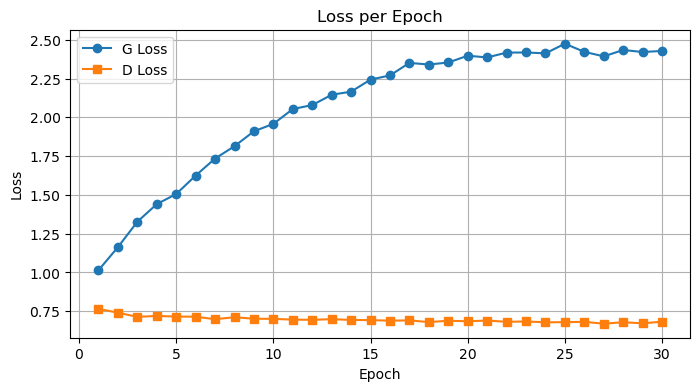

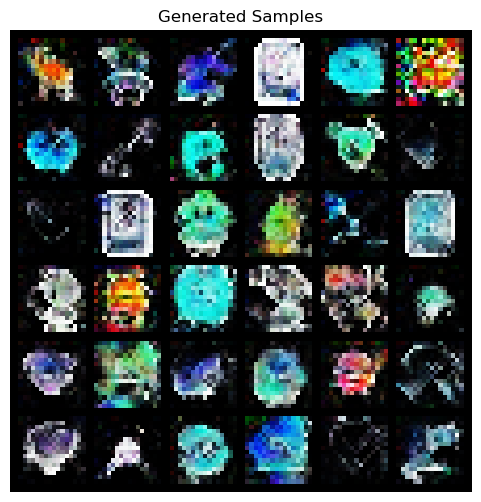

Saved checkpoints at epoch 30
Training complete.


In [41]:
import torch
import torchvision.utils as vutils
from IPython.display import clear_output
import matplotlib.pyplot as plt

# ====== ตัวเลือกปรับแต่ง ======
use_ttur = True          # ใช้ TTUR ไหม (ตั้ง lr_d < lr_g ด้านนอกจะดีที่สุด)
extra_g_when_d_strong = True  # ถ้า D loss ต่ำมาก ให้เทรน G เพิ่ม
plot_every = 5           # อัปเดตกราฟทุกกี่ epoch
sigma0 = 0.05            # instance noise เริ่มต้น (จะค่อย ๆ ลดลง)

num_epochs = 30
batch_size = 64

g_losses, d_losses, epochs_list = [], [], []

def maybe_reshape_to_column(x):
    return x.view(-1, 1) if x.dim() == 1 else x

def add_instance_noise(x, sigma):
    if sigma <= 0: 
        return x
    noise = sigma * torch.randn_like(x)
    x_noisy = (x + noise).clamp(-1, 1)   # ค่าภาพเราปกติอยู่ใน [-1,1]
    return x_noisy

print("Starting training loop...")
for epoch in range(num_epochs):
    running_g, running_d, n_batches = 0.0, 0.0, 0
    
    sigma = sigma0 * ((1 - epoch / max(1, num_epochs - 1)) ** 2)

    # (ออปชัน) TTUR: ปรับ LR ราย epoch เล็กน้อย (ถ้าอยาก)
    if use_ttur:
        for pg in optimizer_d.param_groups:
            pg['lr'] = max(pg['lr'] * 0.999, 1e-5)   # ค่อย ๆ ลด lr_d
        for pg in optimizer_g.param_groups:
            pg['lr'] = pg['lr']                     # lr_g คงเดิม

    for i, batch in enumerate(dataloader):
        real_images = batch[0] if isinstance(batch, (list, tuple)) else batch
        real_images = real_images.to(device)
        bsz = real_images.size(0)
        n_batches += 1

        # ----- labels: smoothing แบบสุ่มช่วง -----
        real_labels = torch.empty(bsz, 1, device=device).uniform_(0.85, 1.00)
        fake_labels = torch.empty(bsz, 1, device=device).uniform_(0.00, 0.15)

        # ================== Train D ==================
        optimizer_d.zero_grad()

        # real (ใส่ instance noise เล็กน้อย)
        real_noisy = add_instance_noise(real_images, sigma)
        out_real = maybe_reshape_to_column(discriminator(real_noisy))
        d_loss_real = criterion(out_real, real_labels)
        d_loss_real.backward()

        # fake (detach G)
        z = torch.randn(bsz, latent_dim, device=device)
        fake_images = generator(z).detach()
        fake_noisy = add_instance_noise(fake_images, sigma)
        out_fake = maybe_reshape_to_column(discriminator(fake_noisy))
        d_loss_fake = criterion(out_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # ================== Train G (อย่างน้อย 1 ครั้ง) ==================
        optimizer_g.zero_grad()
        z = torch.randn(bsz, latent_dim, device=device)
        fake_images = generator(z)
        out_fake = maybe_reshape_to_column(discriminator(fake_images))
        g_loss = criterion(out_fake, torch.ones(bsz, 1, device=device))
        g_loss.backward()
        optimizer_g.step()

        # (ออปชัน) ถ้า D ชนะมาก เทรน G เพิ่มอีก 1 รอบ
        if extra_g_when_d_strong and d_loss.item() < 0.6:
            optimizer_g.zero_grad()
            z = torch.randn(bsz, latent_dim, device=device)
            fake_images = generator(z)
            out_fake = maybe_reshape_to_column(discriminator(fake_images))
            g_loss2 = criterion(out_fake, torch.ones(bsz, 1, device=device))
            g_loss2.backward()
            optimizer_g.step()
            g_loss = (g_loss + g_loss2) / 2.0  # เก็บเป็นค่าเฉลี่ยเพื่อ logging

        running_d += d_loss.item()
        running_g += g_loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Batch [{i+1}/{len(dataloader)}] "
                  f"D: {d_loss.item():.4f} | G: {g_loss.item():.4f} | sigma={sigma:.4f}")

    # ---- log ต่อ epoch ----
    d_losses.append(running_d / max(n_batches, 1))
    g_losses.append(running_g / max(n_batches, 1))
    epochs_list.append(epoch + 1)

    # ---- live plot ----
    if (epoch + 1) % plot_every == 0 or (epoch + 1) == num_epochs:
        clear_output(wait=True)
        plt.figure(figsize=(8,4))
        plt.title("Loss per Epoch")
        plt.plot(epochs_list, g_losses, label="G Loss", marker='o')
        plt.plot(epochs_list, d_losses, label="D Loss", marker='s')
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
        plt.show()

        # แสดงตัวอย่างภาพ
        with torch.no_grad():
            z = torch.randn(36, latent_dim, device=device)
            fake = generator(z)
            grid = vutils.make_grid(fake.detach().cpu(), nrow=6, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(6,6)); plt.axis("off"); plt.title("Generated Samples")
        plt.imshow(grid.permute(1,2,0)); plt.show()

    # ---- checkpoint ทุก 10 epoch ----
    if (epoch + 1) % 10 == 0 and 'save_checkpoint' in globals():
        save_checkpoint(generator, discriminator, epoch + 1, checkpoint_dir)

print("Training complete.")


In [ ]:
# # ...existing code...
# import os
# import re
# import torch

# # Candidate checkpoint directories to check (add more if you use a different name)
# candidate_dirs = [
#     "gen_checkpoints",
#     "./gen_checkpoints",
#     "gan_checkpoints",
#     "./gan_checkpoints",
#     os.path.join(os.getcwd(), "gen_checkpoints"),
#     os.path.join(os.getcwd(), "gan_checkpoints"),
# ]

# # Find the first existing directory from candidates
# checkpoint_dir = next((d for d in candidate_dirs if os.path.exists(d) and os.path.isdir(d)), None)

# if checkpoint_dir is None:
#     raise FileNotFoundError(
#         "No checkpoint directory found. Checked: "
#         + ", ".join(candidate_dirs)
#         + "\nCreate one or update `checkpoint_dir` to the correct path."
#     )

# pattern = re.compile(r"generator_epoch_(\d+)\.pth")

# # List and filter files matching the pattern
# try:
#     files = os.listdir(checkpoint_dir)
# except Exception as e:
#     raise FileNotFoundError(f"Could not list directory '{checkpoint_dir}': {e}")

# generator_files = [f for f in files if pattern.match(f)]

# if not generator_files:
#     raise FileNotFoundError(
#         f"No generator checkpoint files found in '{checkpoint_dir}'.\n"
#         f"Files present: {files}"
#     )

# # Pick latest by epoch number
# latest_file = max(generator_files, key=lambda x: int(pattern.match(x).group(1)))
# latest_path = os.path.normpath(os.path.join(checkpoint_dir, latest_file))

# print(f"Loading latest checkpoint: {latest_file} from {checkpoint_dir}")

# # Load checkpoint into model
# try:
#     generator.load_state_dict(torch.load(latest_path, map_location=device))
#     generator.eval()
#     print("Checkpoint loaded successfully.")
# except Exception as e:
#     raise RuntimeError(f"Failed to load checkpoint '{latest_path}': {e}")
# # ...existing code...

Loading latest checkpoint: generator_epoch_30.pth from gan_checkpoints
Checkpoint loaded successfully.


In [ ]:
# sample_img, _ = next(iter(dataloader))
# print(sample_img.shape)

torch.Size([64, 3, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

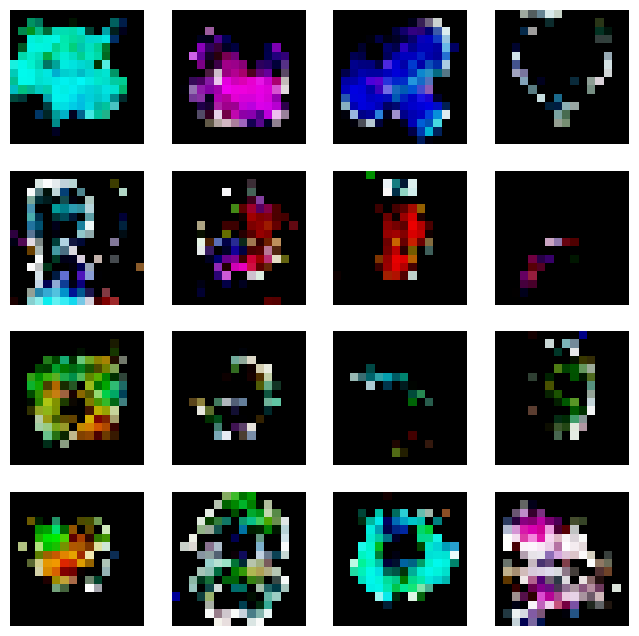

In [ ]:
# # ตรวจขนาดภาพจาก dataloader
# sample_img, _ = next(iter(dataloader))
# img_shape = sample_img.shape[1:]  # (C, H, W)

# # สร้างโมเดล
# generator = Generator(latent_dim, img_shape).to(device)
# discriminator = Discriminator(img_shape).to(device)  # บางโครงสร้างของ D ก็ต้องใช้ img_shape เหมือนกัน

# # โหลด weights
# generator.load_state_dict(torch.load("generator_latest.pth", map_location=device))
# generator.eval()

# # ทดสอบ generate
# with torch.no_grad():
#     z = torch.randn(16, latent_dim, device=device)
#     generated_images = generator(z).cpu()

#     plt.figure(figsize=(8,8))
#     for i in range(16):
#         plt.subplot(4,4,i+1)
#         plt.imshow(generated_images[i].permute(1,2,0))
#         plt.axis("off")
#     plt.show()


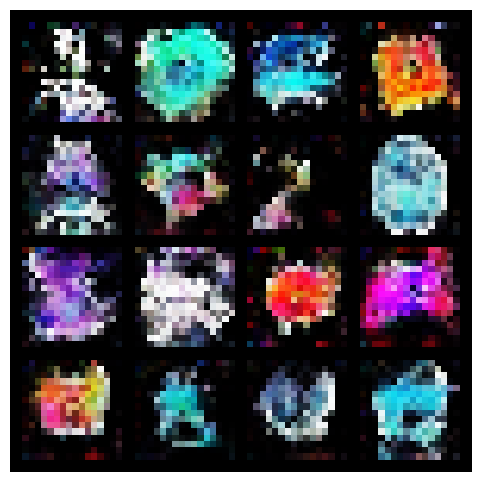

In [ ]:
# import os, torch
# from torchvision.utils import make_grid, save_image
# import matplotlib.pyplot as plt

# # 1) ชี้ไฟล์ epoch 30 โดยตรง
# checkpoint_dir = checkpoint_dir  # ใช้โฟลเดอร์เดิมของคุณ
# pth30 = os.path.join(checkpoint_dir, "generator_epoch_30.pth")
# assert os.path.exists(pth30), f"ไม่พบไฟล์: {pth30}"

# # 2) โหลด weights เข้า generator (ต้องนิยาม generator ให้ตรงกับตอนเทรนก่อน)
# generator.load_state_dict(torch.load(pth30, map_location=device))
# generator.eval()

# # 3) สร้างภาพ
# @torch.no_grad()
# def generate_and_show(n=16, cols=4, save_path=None, denorm="tanh"):
#     z = torch.randn(n, latent_dim, device=device)
#     imgs = generator(z).cpu()  # shape: [N, C, H, W]

#     # ถ้า output ผ่าน tanh ตอนเทรน -> scale จาก [-1,1] -> [0,1]
#     if denorm == "tanh":
#         imgs = (imgs + 1) / 2
#         imgs = imgs.clamp(0, 1)

#     # ทำเป็น grid
#     grid = make_grid(imgs, nrow=cols, padding=2)
#     if save_path:
#         save_image(grid, save_path)

#     # แสดงผล
#     plt.figure(figsize=(6,6))
#     if imgs.size(1) == 1:
#         plt.imshow(grid.squeeze().permute(1,2,0), cmap="gray")
#     else:
#         plt.imshow(grid.permute(1,2,0))
#     plt.axis("off")
#     plt.show()

# # เรียกใช้งาน
# generate_and_show(n=16, cols=4, save_path=os.path.join(checkpoint_dir, "samples_epoch30.png"))


Epoch 5: Generated Images


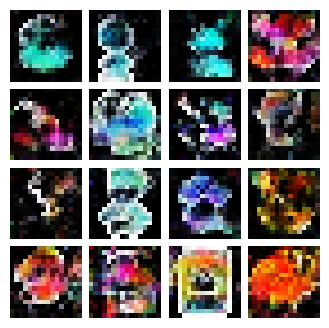

In [33]:
with torch.no_grad():
    # Generate a fixed set of images to visualize progress
    fixed_noise = torch.randn(16, latent_dim).to(device)
    generated_images = generator(fixed_noise).detach().cpu()
    print(f"Epoch {epoch+1}: Generated Images")
    # display_images function should be defined in a previous cell
    display_images(generated_images)